In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

Run the scrublet sample by sample (Be careful about the threshold of cutoff)

In [3]:
input_dir = '/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-cellrange_counts/PWH26D1/outs/filtered_feature_bc_matrix/'

counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(input_dir + '/features.tsv', delimiter='\t', column=1))
out_df = pd.read_csv(input_dir + '/barcodes.tsv', header = None, index_col=None, names=['barcode'])

print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 5038 rows, 36600 columns
Number of genes in gene list: 36600


In [4]:
#See the command parameters
#help(scr.Scrublet)

In [5]:
#expected rate according to 10X protocol
exp=0.008*counts_matrix.shape[0]/1000
print(exp)

0.040304

In [6]:
#expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter.
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=exp)

In [7]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.5%
Overall doublet rate:
	Expected   = 4.0%
	Estimated  = 6.3%
Elapsed time: 6.6 seconds


In [ ]:
# check the doublet score distribution
MED = np.median(doublet_scores)
print(MED)
MAD = robust.mad(doublet_scores)
print(MAD)
CUT = (MED + (3 * MAD))
print(CUT)

In [8]:
#set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram.
#here we set the threshold according to the doublet scores
predicted_doublets = scrub.call_doublets(threshold =CUT)

print(np.array(predicted_doublets))
print(np.count_nonzero(predicted_doublets == True))
#print(arr.count("True"))
#doublets proportation
print (scrub.detected_doublet_rate_)

Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 35.1%
Overall doublet rate:
	Expected   = 4.0%
	Estimated  = 10.1%
[False False False ... False False False]
179
0.035529972211194916


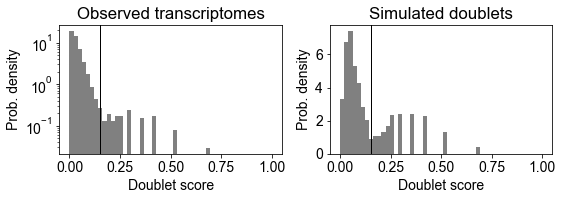

In [10]:
scrub.plot_histogram();
plt.savefig('PWH26D1_scrublet_0.04_0.15_hist.pdf')

Running UMAP...


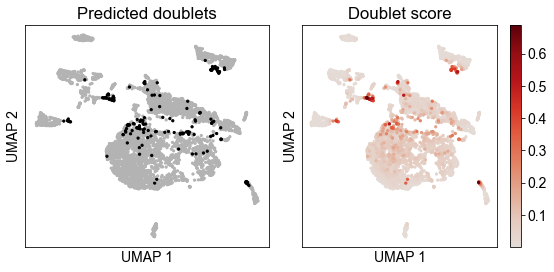

In [11]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)

plt.savefig('PWH26D1_scrublet_0.04_0.15_umap.pdf')

In [12]:
#Save the results with the barcode information
out_df['doublet_scores'] = doublet_scores
out_df['predicted_doublets'] = predicted_doublets
out_df.to_csv('PWH26D1_scrublet_0.04_0.15_doublets.txt', index=False, header=True)
out_df.head()

,barcode,doublet_scores,predicted_doublets
0,AAACCCAAGCCTCTTC-1,0.031235,False
1,AAACCCAAGGCCTGAA-1,0.009610,False
2,AAACCCAAGTACGAGC-1,0.031235,False
3,AAACCCAAGTCAATCC-1,0.083095,False
4,AAACCCATCCCTCAAC-1,0.030075,False


In [ ]:
out_df['predicted_doublets'].value_counts()